This notebook will implement changing lora settings and separate dataloader

In [1]:
# !pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
# transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 umap-learn==0.5.5 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
# matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

In [2]:
# try with UMAP

In [1]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
# from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
# from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from transformers import EsmModel, EsmConfig, EsmTokenizer


# Initializing a ESM facebook/esm-1b style configuration >>> configuration = EsmConfig()

# Initializing a model from the configuration >>> model = ESMModel(configuration)

# Accessing the model configuration >>> configuration = model.config

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.4
Pandas version:  2.1.3
Transformers version:  4.35.2
Datasets version:  2.15.0


In [3]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/train_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

local_fasta_path = '../src/input_datasets/train_Pos_Neg_Y.fasta'

for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P24928|RPB1_HUMAN%1775%1791,NYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPS,1
1,sp|P05787|K2C8_HUMAN%58%74,SGMGGITAVTVNQSLLSPLVLEVDPNIQAVRTQ,1
2,sp|Q14832|GRM3_HUMAN%829%845,QPQKNVVTHRLHLNRFSVSGTGTTYSQSSASTY,1
3,sp|P01106|MYC_HUMAN%46%62,SEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVT,1
4,sp|Q92736|RYR2_HUMAN%2792%2808,TREGDSMALYNRTRRISQTSQVSVDAAHGYSPR,1


In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(1584, 2)

Validation Set:
(396, 2)


In [5]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self, lora_rank=8, lora_init_scale=0.01, lora_scaling_rank=2):
        self.lora_rank = lora_rank
        self.lora_init_scale = lora_init_scale
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = lora_scaling_rank
        # lora_modules and lora_layers are specified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [6]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class ESMClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
   
        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, hidden_states):
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]

        # Apply trainable emphasis factor
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with the average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits
    
from transformers import PreTrainedModel, EsmModel, EsmConfig

class ESMForSequenceClassification(PreTrainedModel):
    config_class = EsmConfig

    def __init__(self, config: EsmConfig, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.esm_model = EsmModel(config)
        self.classifier = ESMClassificationHead(config, class_config)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.esm_model(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = MSELoss()
                loss = loss_fct(logits.squeeze(), labels.squeeze())
            elif self.num_labels > 1 and labels.dtype in (torch.long, torch.int):
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            else:
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [7]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


def ESM_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
    model_checkpoint = "facebook/esm2_t36_3B_UR50D"

    # Load PT5 and tokenizer
    tokenizer = EsmTokenizer.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/")
    model = EsmModel.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/")
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
    class_model = ESMForSequenceClassification(model.config, class_config)
    
    # # Set encoder and embedding weights to checkpoint weights
    # class_model.shared=model.shared
    # class_model.encoder=model.encoder    
    
    # # Delete the checkpoint model
    class_model.esm_model = model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_LoRA_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.classifier.named_parameters():
        param.requires_grad = True

    # for (param_name, param) in model.named_parameters():
    #         if re.fullmatch(config.trainable_param_names, param_name):
    #             param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [9]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [8]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output', filename='finetuned_model'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir
        self.filename = filename
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, self.filename))
            print(f"Saved improved model to {self.output_dir}/{self.filename}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [9]:
from sklearn.metrics import accuracy_score
#!pip install seaborn
import seaborn as sns
import gc

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()
    
# Main training fuction
def train_per_protein(
        train_dataset,         #training data
        valid_dataset,         #validation data      
        weight_decay,
        warmup_pct,
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs=1,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1,
        dropout=0.5, #dropout rate
         #L2 weight regularization
        lora_rank=4,      #lora rank
        lora_init_scale=0.01, #lora scaling rank
        lora_scaling_rank=1,       #lora a
        ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = ESM_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)

    # Huggingface Trainer arguments
    total_steps = epochs * len(train_dataset) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='no',
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,         # load the best model at the end of training
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
        logging_dir='./logs',
    )
    # metric_for_best_model='eval_loss|accuracy'

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # For maximizing accuracy
    early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
            early_stopping_patience=3,
            min_delta=0.001,
            output_dir='./model_output',
            filename='finetuned_model_all_esm2_smac.pth'
        )],
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

        
    # Train model
    trainer.train()

    # Get the best model
    # model = trainer.model
    # Ensure the best model is loaded
    best_model_path = os.path.join('./model_output', 'finetuned_model_all_esm2_smac.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    torch.cuda.empty_cache()
    gc.collect()

    return tokenizer, model, trainer.state.log_history


In [10]:
# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset

# Initialize the tokenizer
model_checkpoint = "facebook/esm2_t36_3B_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/")
# tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False, force_download=True) 

train_df = my_train
valid_df = my_valid

# Preprocess inputs
# Replace uncommon AAs with "X"
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# Add spaces between each amino acid for PT5 to correctly use them
train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

# Create Datasets
train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
from __future__ import annotations

import warnings
import numpy as np
import json
import logging
import os
from ConfigSpace import ConfigurationSpace, Configuration
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, CategoricalHyperparameter, UniformIntegerHyperparameter
from smac import HyperparameterOptimizationFacade as HPOFacade
from smac import Scenario
from smac.intensifier.hyperband import Hyperband
from smac.multi_objective.parego import ParEGO
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

class ProteinModel:
    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace()

        cs.add_hyperparameters([
            UniformFloatHyperparameter('lr', lower=1e-5, upper=1e-2, log=True),
            CategoricalHyperparameter('batch', choices=[1, 2, 4, 8]),
            CategoricalHyperparameter('accum', choices=[2, 4, 8]),
            UniformFloatHyperparameter('dropout_rate', lower=0.1, upper=0.9),
            UniformFloatHyperparameter('weight_decay', lower=1e-5, upper=1e-3, log=True),
            UniformFloatHyperparameter('warmup_pct', lower=0.01, upper=0.3),
            UniformIntegerHyperparameter('lora_rank', lower=4, upper=32),
            UniformFloatHyperparameter('lora_init_scale', lower=1e-4, upper=1e-1, log=True),
            UniformIntegerHyperparameter('lora_scaling_rank', lower=1, upper=4)
        ])

        cs['lora_rank'].q = 4

        return cs

    def train(self, config: Configuration, seed: int = 42, budget: int = 10) -> dict[str, float]:
        logger.info(f"Training with budget (epochs): {budget}")
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")

            # Call your training function
            tokenizer, model, history = train_per_protein(
                train_dataset=train_set,
                valid_dataset=valid_set,
                num_labels=2,
                batch=int(config['batch']),
                accum=int(config['accum']),
                epochs=int(budget),
                lr=config['lr'],
                dropout=config['dropout_rate'],
                weight_decay=config['weight_decay'],
                warmup_pct=config['warmup_pct'],
                lora_rank=config['lora_rank'],
                lora_init_scale=config['lora_init_scale'],
                lora_scaling_rank=config['lora_scaling_rank'],
                seed=seed
            )

            # Extract the last validation accuracy and loss from the history
            val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
            val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]

        logger.info(f"Completed training. Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
        return {
            "val_loss": val_loss,
            "1 - val_accuracy": 1 - val_accuracy,  # We minimize, so we use 1 - accuracy
        }

def plot_pareto(smac: HPOFacade, incumbents: list[Configuration]) -> None:
    """Plots configurations from SMAC and highlights the best configurations in a Pareto front."""
    average_costs = []
    average_pareto_costs = []
    for config in smac.runhistory.get_configs():
        # Since we use multiple seeds, we have to average them to get only one cost value pair for each configuration
        average_cost = smac.runhistory.average_cost(config)

        if config in incumbents:
            average_pareto_costs += [average_cost]
        else:
            average_costs += [average_cost]

    # Let's work with a numpy array
    costs = np.vstack(average_costs)
    pareto_costs = np.vstack(average_pareto_costs)
    pareto_costs = pareto_costs[pareto_costs[:, 0].argsort()]  # Sort them

    costs_x, costs_y = costs[:, 0], costs[:, 1]
    pareto_costs_x, pareto_costs_y = pareto_costs[:, 0], pareto_costs[:, 1]

    plt.scatter(costs_x, costs_y, marker="x", label="Configuration")
    plt.scatter(pareto_costs_x, pareto_costs_y, marker="x", c="r", label="Incumbent")
    plt.step(
        [pareto_costs_x[0]] + pareto_costs_x.tolist() + [np.max(costs_x)],  # We add bounds
        [np.max(costs_y)] + pareto_costs_y.tolist() + [np.min(pareto_costs_y)],  # We add bounds
        where="post",
        linestyle=":",
    )

    plt.title("Pareto-Front")
    plt.xlabel(smac.scenario.objectives[0])
    plt.ylabel(smac.scenario.objectives[1])
    plt.legend()
    plt.show()

if __name__ == "__main__":
    protein_model = ProteinModel()
    objectives = ["val_loss", "1 - val_accuracy"]

    # Define output directory
    output_dir = "./smac3_output"
    os.makedirs(output_dir, exist_ok=True)

    # Define our environment variables
    scenario = Scenario(
        protein_model.configspace,
        objectives=objectives,
        # walltime_limit=1800,  # After 30 minutes, we stop the hyperparameter optimization
        n_trials=30,  # Evaluate up to 30 different configurations
        min_budget=5,
        max_budget=20,
        n_workers=1,
        output_directory=output_dir,
        name="ProteinModelOptimization_4",
    )

    # We want to run five random configurations before starting the optimization.
    initial_design = HPOFacade.get_initial_design(scenario, n_configs=5)

    intensifier = HPOFacade.get_intensifier(scenario, max_config_calls=2)

    # Set up the multi-objective optimizer
    multi_objective_algorithm = ParEGO(scenario=scenario)

    # Create our SMAC object and pass the scenario and the train method
    smac = HPOFacade(
        scenario,
        protein_model.train,
        initial_design=initial_design,
        multi_objective_algorithm=multi_objective_algorithm,
        intensifier=intensifier,
        overwrite=True,
    )

    # Let's optimize
    incumbents = smac.optimize()

    # Prepare results
    # all_runs = []

    print("**************")
    print("\nBest configurations:")
    for incumbent in incumbents:
        print("Configuration: ", incumbent)
        print("Average Cost: ", smac.runhistory.average_cost(incumbent))
        print("Value: ", smac.runhistory.get_cost(incumbent))
        print("Hyperparameters: ", dict(incumbent))
        # print("---", cost)

    # Let's plot a pareto front
    plot_pareto(smac, incumbents)

/tmp/ipykernel_814720/1541834543.py:35: DeprecationWarning: Please use `space.add(hyperparameters)`
  cs.add_hyperparameters([
2024-08-09 10:25:54,133 - INFO - Using `n_configs` and ignoring `n_configs_per_hyperparameter`.


[WARNING][target_function_runner.py:74] The argument budget is not set by SMAC: Consider removing it from the target function.
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:28<00:00, 44.01s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.677900,1.003294,0.631313
2,0.888100,1.262189,0.595960
3,1.176100,1.177082,0.626263
4,1.745800,1.894938,0.595960


Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2_smac.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 1.0032942295074463, 'eval_accuracy': 0.6313131313131313, 'eval_runtime': 8.769, 'eval_samples_per_second': 45.159, 'eval_steps_per_second': 5.702, 'epoch': 4.0}
[INFO][1541834543.py:79] Completed training. Val Loss: 1.0032942295074463, Val Accuracy: 0.6313131313131313
[INFO][abstract_intensifier.py:516] Added config b74743 as new incumbent because there are no incumbents yet.
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:54<00:00, 27.27s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.697300,1.811024,0.515152
2,0.938800,1.941353,0.535354
3,1.426100,0.687574,0.722222
4,1.853000,2.636436,0.654040
5,1.831500,2.248864,0.613636
6,1.833700,3.582867,0.507576


Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2_smac.pth


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6875739097595215, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 8.7814, 'eval_samples_per_second': 45.095, 'eval_steps_per_second': 5.694, 'epoch': 6.0}
[INFO][1541834543.py:79] Completed training. Val Loss: 0.6875739097595215, Val Accuracy: 0.7222222222222222
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards: 100%|███████████████████████████████████████| 2/2 [02:22<00:00, 71.41s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.710000,0.685675,0.641414
2,0.713000,0.671545,0.689394
3,0.693200,0.653400,0.679293
4,0.669100,0.632464,0.704545
5,0.655100,0.613528,0.717172
6,0.641300,0.596668,0.712121
7,0.628200,0.582899,0.714646
8,0.613200,0.579749,0.684343
9,0.600400,0.562352,0.727273
10,0.574300,0.558424,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Loaded best model from ./model_output/finetuned_model_all_esm2_smac.pth


{'eval_loss': 0.5584241151809692, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 8.7732, 'eval_samples_per_second': 45.137, 'eval_steps_per_second': 5.699, 'epoch': 10.0}
[INFO][1541834543.py:79] Completed training. Val Loss: 0.5584241151809692, Val Accuracy: 0.7373737373737373
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards: 100%|███████████████████████████████████████| 2/2 [01:52<00:00, 56.11s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.713400,0.689258,0.532828
2,0.720400,0.674987,0.651515
3,0.686800,0.656059,0.661616
4,0.676400,0.634075,0.681818
5,0.655200,0.616514,0.694444
6,0.644800,0.599607,0.691919
7,0.616700,0.588876,0.696970
8,0.602000,0.572509,0.714646
9,0.589700,0.560597,0.722222
10,0.578100,0.559558,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Loaded best model from ./model_output/finetuned_model_all_esm2_smac.pth


{'eval_loss': 0.5595582127571106, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 8.7934, 'eval_samples_per_second': 45.034, 'eval_steps_per_second': 5.686, 'epoch': 10.0}
[INFO][1541834543.py:79] Completed training. Val Loss: 0.5595582127571106, Val Accuracy: 0.7323232323232324
[INFO][abstract_intensifier.py:595] Added config 8648e5 and rejected config b74743 as incumbent because it is not better than the incumbents on 2 instances:
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards: 100%|███████████████████████████████████████| 2/2 [02:55<00:00, 87.89s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



Epoch,Training Loss,Validation Loss,Accuracy
0,0.649800,0.565377,0.702020
2,0.542300,0.529242,0.737374
4,0.466700,0.538562,0.737374
6,0.434900,0.565411,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Stopping early at epoch 6.98989898989899: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2_smac.pth


Stopping early at epoch 6.98989898989899: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5425368547439575, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 8.767, 'eval_samples_per_second': 45.169, 'eval_steps_per_second': 5.703, 'epoch': 6.99}
[INFO][1541834543.py:79] Completed training. Val Loss: 0.5425368547439575, Val Accuracy: 0.7424242424242424
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards: 100%|███████████████████████████████████████| 2/2 [02:12<00:00, 66.48s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



Epoch,Training Loss,Validation Loss,Accuracy
0,0.655700,0.568374,0.686869
2,0.551600,0.808439,0.616162
4,0.508100,0.553472,0.719697
6,0.455000,0.558257,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Stopping early at epoch 6.98989898989899: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2_smac.pth


Stopping early at epoch 6.98989898989899: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5282009243965149, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 8.7558, 'eval_samples_per_second': 45.227, 'eval_steps_per_second': 5.71, 'epoch': 6.99}
[INFO][1541834543.py:79] Completed training. Val Loss: 0.5282009243965149, Val Accuracy: 0.7424242424242424
[INFO][abstract_intensifier.py:595] Added config 5d50d2 and rejected config 8648e5 as incumbent because it is not better than the incumbents on 2 instances:
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards: 100%|███████████████████████████████████████| 2/2 [02:40<00:00, 80.12s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.763900,0.631166,0.671717
2,0.730600,0.656924,0.628788
3,0.780700,0.558730,0.712121
4,0.781800,0.578362,0.686869
5,0.843600,0.554034,0.704545
6,0.792300,0.591985,0.666667
7,0.784800,0.569668,0.686869
8,0.760800,0.582382,0.689394


Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2_smac.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5540337562561035, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 8.7776, 'eval_samples_per_second': 45.115, 'eval_steps_per_second': 5.696, 'epoch': 8.0}
[INFO][1541834543.py:79] Completed training. Val Loss: 0.5540337562561035, Val Accuracy: 0.7045454545454546
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:49<00:00, 54.61s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



Epoch,Training Loss,Validation Loss,Accuracy
1,0.772400,0.656064,0.616162
2,0.764300,0.593832,0.684343
3,0.756700,0.568881,0.686869
4,0.841200,0.562978,0.699495
5,0.792000,0.574070,0.712121
6,0.801600,0.602183,0.684343
7,0.775200,0.545487,0.739899
8,0.722200,0.543772,0.737374
9,0.726400,0.542227,0.732323
10,0.756500,0.541344,0.729798


Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Saved improved model to ./model_output/finetuned_model_all_esm2_smac.pth
Loaded best model from ./model_output/finetuned_model_all_esm2_smac.pth


{'eval_loss': 0.542227029800415, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 8.795, 'eval_samples_per_second': 45.026, 'eval_steps_per_second': 5.685, 'epoch': 10.0}
[INFO][1541834543.py:79] Completed training. Val Loss: 0.542227029800415, Val Accuracy: 0.7323232323232324
[INFO][1541834543.py:52] Training with budget (epochs): 10


Loading checkpoint shards:   0%|                                                              | 0/2 [00:00<?, ?it/s]

: 

In [13]:
tokenizer, model, history = train_per_protein(train_set, valid_set, num_labels=2, batch=4, accum=4, epochs=20, seed=42, lr=0.0003459380673689418, dropout=0.6303139405233136, weight_decay=7.145415686725527e-05, warmup_pct=0.12121786012551566, lora_rank=20, lora_init_scale=0.004413381171295235, lora_scaling_rank=3)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:07<00:00,  4.00s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.706800,0.642258,0.704545
2,0.648500,0.584324,0.709596
3,0.601200,0.550624,0.729798
4,0.567000,0.545805,0.719697
5,0.553400,0.528095,0.734848
6,0.562000,0.539324,0.727273
7,0.562800,0.544778,0.727273
8,0.550300,0.523778,0.729798
9,0.535300,0.531071,0.739899
10,0.524700,0.548785,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 12.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


Stopping early at epoch 12.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5310714244842529, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 8.6859, 'eval_samples_per_second': 45.591, 'eval_steps_per_second': 5.756, 'epoch': 12.0}


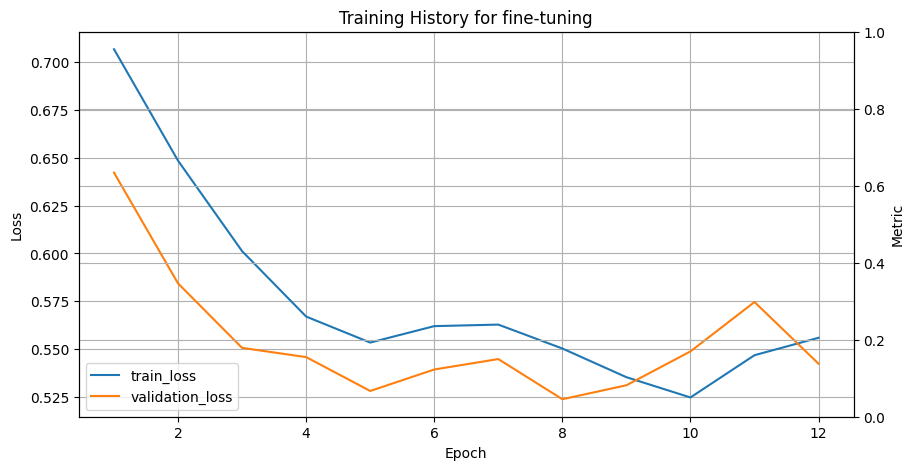

In [14]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

lr 0.0003459380673689418
batch 4
accum 4
dropout_rate 0.6303139405233136
weight_decay 7.145415686725527e-05
warmup_pct 0.12121786012551566
lora_rank 20
lora_init_scale 0.004413381171295235
lora_scaling_rank 3

In [15]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = ESM_classification_model(num_labels=num_labels, dropout=0.6303139405233136, lora_rank=20, lora_init_scale=0.004413381171295235, lora_scaling_rank=3)
    # model_checkpoint = "facebook/esm2_t36_3B_UR50D"
    # tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    # model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [16]:
# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_all_esm2_smac.pth",num_labels=2)

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.55s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



In [17]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have different weights


In [18]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/test_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])
    
local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WUI4|HDAC7_HUMAN%342%358,ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM,1
1,sp|Q13950|RUNX2_HUMAN%416%432,THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG,1
2,sp|Q15796|SMAD2_HUMAN%229%245,DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL,1
3,sp|P05787|K2C8_HUMAN%416%432,TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG,1
4,sp|Q92736|RYR2_HUMAN%2798%2814,MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN,1


In [19]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM      1
1  THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG      1
2  DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL      1
3  TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG      1
4  MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN      1


In [20]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = sequence.split()
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
my_test['middle_char'] = my_test['sequence'].apply(get_middle_char)

# Split the DataFrame
my_test_S = my_test[my_test['middle_char'] == 'S'].drop(columns=['middle_char'])
my_test_T = my_test[my_test['middle_char'] == 'T'].drop(columns=['middle_char'])
my_test_Y = my_test[my_test['middle_char'] == 'Y'].drop(columns=['middle_char'])
my_test_ST = my_test[my_test['middle_char'].isin(['S', 'T'])].drop(columns=['middle_char'])

In [21]:
my_test = my_test_Y

In [22]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.762821 |      0.846154 |      0.916667 |       0.88 |  0.956731 |
+----------+---------------+---------------+------------+-----------+
[[22  4]
 [ 2 22]]


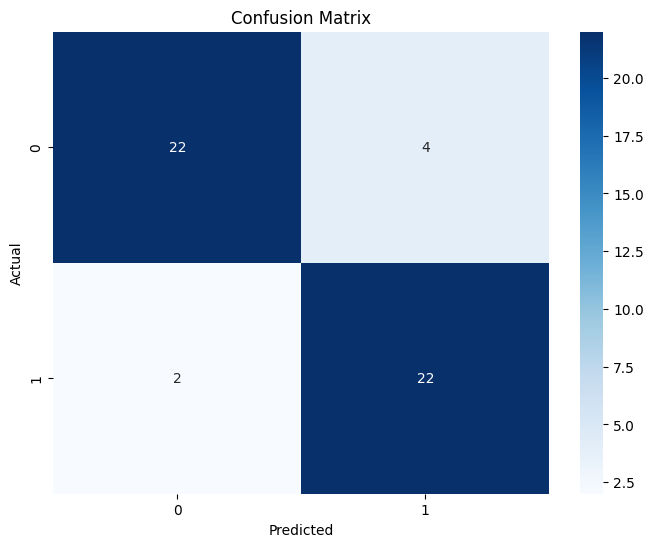

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()


In [24]:
my_test = my_test_ST

In [25]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.29it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.536105 |        0.6875 |      0.842342 |   0.764574 |  0.854448 |
+----------+---------------+---------------+------------+-----------+
[[154  70]
 [ 35 187]]


In [20]:
import umap

def apply_umap(embeddings, n_components=2, n_neighbors=5, min_dist=0.01, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_umap(embeddings, labels):
    df = pd.DataFrame({
        "UMAP1": embeddings[:, 0],
        "UMAP2": embeddings[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9
    )
    plt.title("UMAP Visualization of Embeddings")
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_ST.pdf", bbox_inches='tight')
    plt.show()
    
def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
    embeddings = []
    model = model.to(device)
    model.eval()

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
            embeddings.extend(hidden_states[:, 0, :])

        print(f"Processed batch {i // batch_size + 1}/{len(sequences) // batch_size + 1}")

    return np.array(embeddings)

In [38]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

valid_df = df

# Apply the function to get the middle characters
valid_df['middle_char'] = valid_df['sequence'].apply(get_middle_char)

valid_df = valid_df[valid_df['middle_char'] == 'T'].drop(columns=['middle_char'])

In [39]:
valid_df

,name,sequence,label
180,sp|Q9GZM8|NDEL1_HUMAN%203%219,CEKMDSAVQASLSLPATPVGKGTENTFPSPKAI,1
181,sp|Q8N163|CCAR2_HUMAN%438%454,EWEALCQQKAAEAAPPTQEAQGETEPTEQAPDA,1
182,sp|P10636-8|TAU_HUMAN%196%212,GYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAV,1
183,sp|Q02241|KIF23_HUMAN%434%450,QEVEVARPVDKAICGLTPGRRYRNQPRGPVGNE,1
184,sp|Q04206|TF65_HUMAN%419%435,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLG,1
...,...,...,...
441,sp|Q76N33|STALP_MOUSE%326%342,ENVEELFNVQDQHGLLTLGWIHTHPTQTAFLSS,0
442,sp|P49790|NU153_HUMAN%1098%1114,FVLGRTEEKQQEPVTSTSLVFGKKADNEEPKCQ,0
443,sp|Q8NFC6|BD1L1_HUMAN%2789%2805,DVLDSRIETAQRQCPETEPHDTKEENSRDLEEL,0
444,sp|Q5T6F2|UBAP2_HUMAN%514%530,SKIPASAVEMPGSADVTGLNVQFGALEFGSEPS,0


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0

Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


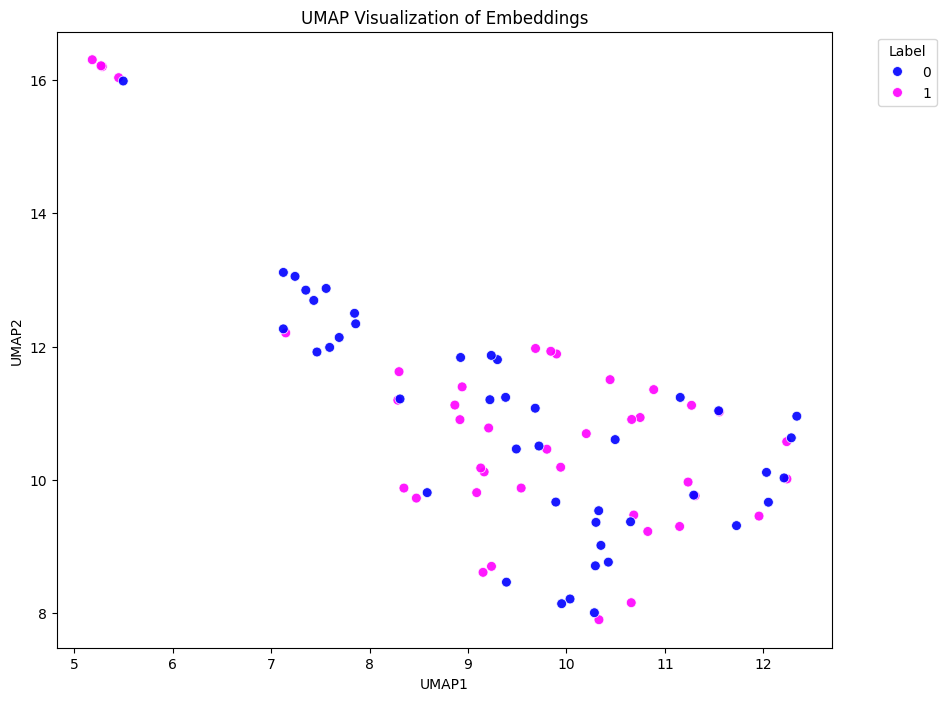

In [40]:
# valid_df = my_valid

# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].apply(lambda x: " ".join(x))

valid_sequences = list(valid_df['sequence'])
valid_embeddings = get_embeddings(model_reload, tokenizer, valid_sequences)

umap_embeddings = apply_umap(valid_embeddings)


labels = list(valid_df['label'])

plot_umap(umap_embeddings, labels)
